#**Examining NFL Offenses on Third Down**
The National Football League (NFL) is the most popular sports league in the United States. The basis of play is that each team has four chances to advance the ball ten yards. The most important of these trys is the third, referred to as third down. If the offense fails to advance ten total yards by their third try, most teams will elect to punt the ball to the opposing team on their fourth and final try, effectively ending their offensive possession. Being successful on third down is crucial for NFL defenses to stop the opposing offense and gain possession of the ball for their own team.


## Connecting to the Data Source
The data set being used for this analysis contains every play that occured in the NFL from 2009-2018. This data was compiled by Carnegie Mellon University statistical researchers including Maksim Horowitz, Ron Yurko, and Sam Ventura. The data set contains around 450,000 rows and 250 columns and includes detailed information on game situation, players involved, results, and advanced metrics such as expected point and win probability values. The data was accessed through Kaggle at the following link: 
https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016/download.

The data used in this notebook has been mounted from Google Drive and placed into a DataFame. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

nflplay_df = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/NFL Play by Play 2009-2018 (v5).csv')

nflplay_df.head(3)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,...,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,pass_defense_1_player_id,pass_defense_1_player_name,pass_defense_2_player_id,pass_defense_2_player_name,fumbled_1_team,fumbled_1_player_id,fumbled_1_player_name,fumbled_2_player_id,fumbled_2_player_name,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_1_yards,fumble_recovery_1_player_id,fumble_recovery_1_player_name,fumble_recovery_2_team,fumble_recovery_2_yards,fumble_recovery_2_player_id,fumble_recovery_2_player_name,return_team,return_yards,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,900.0,1800.0,3600.0,Half1,0,1,0,1,NaN,0.0,15:00,TEN 30,0,0,R.Bironas kicks 67 yards from TEN 30 to PIT 3....,kickoff,0.0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIT,39.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,893.0,1793.0,3593.0,Half1,0,1,0,1,1.0,0.0,14:53,PIT 42,10,5,(14:53) B.Roethlisberger pass short left to H....,pass,5.0,0,0,1.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,856.0,1756.0,3556.0,Half1,0,1,0,1,2.0,0.0,14:16,PIT 47,5,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,run,-3.0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,right,end,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


## Cleaning and Wrangling the Data
The current DataFrame contains all plays, from first to fourth down attempts. This analysis solely looks at third down, so a new DataFrame is created with only third down plays. Plays where there are null values for 'rush_attempt' or 'pass_attempt' are dropped. 

In [0]:
#cleaning dataframe to only 3rd down plays
third_down_plays = nflplay_df['down'] == 3 
nflplay_third_df = nflplay_df.iloc[third_down_plays.values]
nflplay_third_df_clean = nflplay_third_df.dropna(subset=['rush_attempt', 'pass_attempt'])


A second DataFrame is also created that shows the distance to go, whether the team with posession is winning or losing, and both the percentage of a rushing play or passing play. 

In [0]:
# creating empty list to house third down data
tddf = []

# third down plays while possesion team is winning
def thirddowndataframewinning(data, distance):
  # clean data based on third down, distance, and team winning
  tdp = (data['down'] == 3) & (data['ydstogo'] == distance) & (data['score_differential'] > 0)
  nptd = data.iloc[tdp.values]
  nptdc = nptd.dropna(subset=['rush_attempt', 'pass_attempt'])
  # place data into a list
  row = [distance, 'winning', round((nptdc['rush_attempt'].mean() * 100),2), round((nptdc['pass_attempt'].mean() * 100),2)]
  # append list to third down data
  tddf.append(row)


# third down plays while possesion team is losing
def thirddowndataframelosing(data, distance):
  # clean data based on third down, distance, and team losing
  tdp = (data['down'] == 3) & (data['ydstogo'] == distance) & (data['score_differential'] < 0)
  nptd = data.iloc[tdp.values]
  nptdc = nptd.dropna(subset=['rush_attempt', 'pass_attempt'])
  # place data into a list
  row = [distance, 'losing', round((nptdc['rush_attempt'].mean() * 100),2), round((nptdc['pass_attempt'].mean() * 100),2)]
  # append list to third down data
  tddf.append(row)

# loop over distance to go between 1 and 10
for distance in range(1,11):
  thirddowndataframewinning(nflplay_df, distance)

for distance in range(1,11):
  thirddowndataframelosing(nflplay_df, distance)

# create dataframe from list
thirddown_df = pd.DataFrame(tddf, columns=['distance','score','rush_percentage','pass_percentage'])

thirddown_df.head()

,distance,score,rush_percentage,pass_percentage
0,1,winning,71.17,23.33
1,2,winning,36.32,55.94
2,3,winning,20.92,69.38
3,4,winning,17.52,73.59
4,5,winning,15.83,74.69


## Exploratory Data Analysis
**Do teams run or pass more on third down?**

The null hypothesis for the analysis is that there is no difference in the percentage of run plays or pass plays. For all third down plays, 19.57% plays are rush attempts, and 71.96% are passings plays. The difference in percentage is statistically significant with a p-value of 0. The null hypothesis is rejected and it is determenined that teams attempt pass plays more often on third down than running plays.

In [0]:
# percentage of run and pass plays on all 3rd down plays
print(nflplay_third_df_clean['rush_attempt'].mean())
print(nflplay_third_df_clean['pass_attempt'].mean())

print(stats.ttest_ind(nflplay_third_df_clean['rush_attempt'], nflplay_third_df_clean['pass_attempt']))

0.19573021227022122
0.719632624862844
Ttest_indResult(statistic=-237.50923210119956, pvalue=0.0)


## Deep-Dive Data Analysis
Not all third downs are created equally. Teams can be put into drastically different third down scenarios. Teams can face a short third down attempt, with only two yards to go or be stuck in a long third and eight yard try. They could have possession of the ball with the lead or could be trying to come back from a deficit. 

### Third Down from Multiple Distances
**Do teams run or pass more based on the yards to go on third down?**

The null hypothesis for the analysis is that there is no difference in the percentage of run plays or pass plays for 3rd & 1 through 3rd & 10. Each scenario has a statistically significant difference between the percentage of rush and pass plays. The null hypothesis is rejected and the following is determined:



*   Teams are more likely to run than pass on 3rd Down with 1 yard to go.
*   Teams are more likely to pass than run on 3rd Down with between 2 and 10 yards to go.



In [0]:
def thirddownanalyze(data, distance):
  tdp = (data['down'] == 3) & (data['ydstogo'] == distance)
  nptd = data.iloc[tdp.values]
  nptdc = nptd.dropna(subset=['rush_attempt', 'pass_attempt'])
  print('Statistical Results for 3rd Down & {} yard(s) to go:'.format(distance))
  print('Rush percentage:')
  print(round((nptdc['rush_attempt'].mean() * 100),2),'%')
  print('Pass percetage:')
  print(round((nptdc['pass_attempt'].mean() * 100),2),'%')
  print('Statistical testing for difference in percentage:')
  print(stats.ttest_ind(nptdc['rush_attempt'], nptdc['pass_attempt']))

for distance in range(1,11):
  thirddownanalyze(nflplay_df, distance)
  print('')

Statistical Results for 3rd Down & 1 yard(s) to go:
Rush percentage:
67.44 %
Pass percetage:
26.81 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=56.106972569535344, pvalue=0.0)

Statistical Results for 3rd Down & 2 yard(s) to go:
Rush percentage:
30.67 %
Pass percetage:
61.98 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-35.3485440911856, pvalue=7.660282267677213e-260)

Statistical Results for 3rd Down & 3 yard(s) to go:
Rush percentage:
16.4 %
Pass percetage:
75.12 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-77.78062596361312, pvalue=0.0)

Statistical Results for 3rd Down & 4 yard(s) to go:
Rush percentage:
13.04 %
Pass percetage:
77.69 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-93.24784513872797, pvalue=0.0)

Statistical Results for 3rd Down & 5 yard(s) to go:
Rush percentage:
10.98 %
Pass percetage:
79.88 %
Statistical testing for difference in perc

### Third Down While Winning
**Do teams run or pass more on third down while they are winning?**

The null hypothesis for the analysis is that there is no difference in the percentage of run plays or pass plays for 3rd & 1 through 3rd & 10 while teams are winning. Each scenario has a statistically significant difference between the percentage of rush and pass plays. The null hypothesis is rejected and the following is determined:

* Teams that are winning are more likely to run than pass on 3rd Down with 1 yard to go.
* Teams that are winning are more likely to pass than run on 3rd Down with between 2 and 10 yards to go.


In [0]:
def thirddownanalyzewinning(data, distance):
  tdp = (data['down'] == 3) & (data['ydstogo'] == distance) & (data['score_differential'] > 0)
  nptd = data.iloc[tdp.values]
  nptdc = nptd.dropna(subset=['rush_attempt', 'pass_attempt'])
  print('Statistical Results for 3rd Down & {} yard(s) to go:'.format(distance))
  print('Rush percentage:')
  print(round((nptdc['rush_attempt'].mean() * 100),2),'%')
  print('Pass percetage:')
  print(round((nptdc['pass_attempt'].mean() * 100),2),'%')
  print('Statistical testing for difference in percentage:')
  print(stats.ttest_ind(nptdc['rush_attempt'], nptdc['pass_attempt']))

for distance in range(1,11):
  thirddownanalyzewinning(nflplay_df, distance)
  print('')

Statistical Results for 3rd Down & 1 yard(s) to go:
Rush percentage:
71.17 %
Pass percetage:
23.33 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=41.101334362848135, pvalue=0.0)

Statistical Results for 3rd Down & 2 yard(s) to go:
Rush percentage:
36.32 %
Pass percetage:
55.94 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-12.621749092499824, pvalue=7.804328529568278e-36)

Statistical Results for 3rd Down & 3 yard(s) to go:
Rush percentage:
20.92 %
Pass percetage:
69.38 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-35.69731140789131, pvalue=2.851223019362691e-243)

Statistical Results for 3rd Down & 4 yard(s) to go:
Rush percentage:
17.52 %
Pass percetage:
73.59 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-45.3251492493588, pvalue=0.0)

Statistical Results for 3rd Down & 5 yard(s) to go:
Rush percentage:
15.83 %
Pass percetage:
74.69 %
Statistical testing fo

### Third Down While Losing
**Do teams run or pass more on third down while they are losing?**

The null hypothesis for the analysis is that there is no difference in the percentage of run plays or pass plays for 3rd & 1 through 3rd & 10 while teams are losing. Each scenario has a statistically significant difference between the percentage of rush and pass plays. The null hypothesis is rejected and the following is determined:

* Teams that are losing are more likely to run than pass on 3rd Down with 1 yard to go.
* Teams that are losing are more likely to pass than run on 3rd Down with between 2 and 10 yards to go.


In [0]:
def thirddownanalyzelosing(data, distance):
  tdp = (data['down'] == 3) & (data['ydstogo'] == distance) & (data['score_differential'] < 0)
  nptd = data.iloc[tdp.values]
  nptdc = nptd.dropna(subset=['rush_attempt', 'pass_attempt'])
  print('Statistical Results for 3rd Down & {} yard(s) to go:'.format(distance))
  print('Rush percentage:')
  print(round((nptdc['rush_attempt'].mean() * 100),2),'%')
  print('Pass percetage:')
  print(round((nptdc['pass_attempt'].mean() * 100),2),'%')
  print('Statistical testing for difference in percentage:')
  print(stats.ttest_ind(nptdc['rush_attempt'], nptdc['pass_attempt']))

for distance in range(1,11):
  thirddownanalyzelosing(nflplay_df, distance)
  print('')

Statistical Results for 3rd Down & 1 yard(s) to go:
Rush percentage:
62.33 %
Pass percetage:
31.74 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=27.096200259505476, pvalue=6.157772383247721e-154)

Statistical Results for 3rd Down & 2 yard(s) to go:
Rush percentage:
27.39 %
Pass percetage:
65.61 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-29.819445055301056, pvalue=1.9781732306304876e-180)

Statistical Results for 3rd Down & 3 yard(s) to go:
Rush percentage:
13.9 %
Pass percetage:
78.21 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-59.62937077308785, pvalue=0.0)

Statistical Results for 3rd Down & 4 yard(s) to go:
Rush percentage:
9.22 %
Pass percetage:
80.83 %
Statistical testing for difference in percentage:
Ttest_indResult(statistic=-74.90279325560269, pvalue=0.0)

Statistical Results for 3rd Down & 5 yard(s) to go:
Rush percentage:
8.08 %
Pass percetage:
82.97 %
Statistical testing fo

## Visualizing the Analysis
Results from the analysis are placed into two scatterplots showing the percentage of a rushing play and a passing play. Each scatterplot breaks that data between whether the team with possession of the ball is winning or losing and shows this over distance to go. 



### Rush Percentage Scatterplot

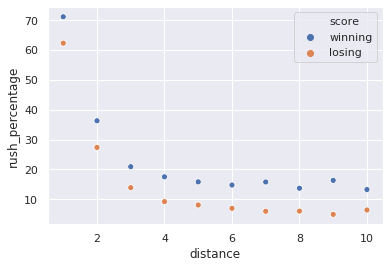

In [0]:
sns.scatterplot(x="distance", y='rush_percentage', hue="score", data=thirddown_df)

### Pass Percentage Scatterplot

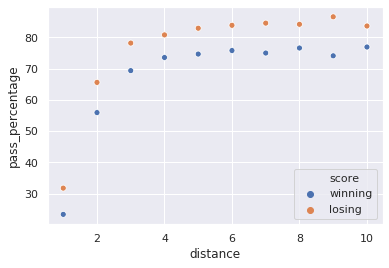

In [0]:
sns.scatterplot(x="distance", y='pass_percentage', hue="score", data=thirddown_df)

## Results
Results from this analysis are useful to NFL defenses and allow them to better defend crucial third down plays. The main takeways that NFL defenses can use are as follows:

* A team is more likely to run on 3rd Down & 1
* A team is more likely to pass on 3rd Down and 2-10
* A team that is losing increases their chance of passing by about 10 percentage points for all 3rd Down attempts.

